In [181]:
## TURN T-SNE INTO GIF
# original source: https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
# tuned for new TSNE by scikit

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.patches as mpatches
import matplotlib
import numpy as np

import sklearn
from sklearn.manifold import TSNE
from scipy import linalg

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [4]:
RS = 2211

In [104]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28*28*1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28*28*1))  # adapt this if using `channels_first` image data format

In [105]:
x, y = x_train[:500], y_train[:500]

In [140]:
# monkey patch gradient descent 

positions = []

def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):

    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    for i in range(it, n_iter):
        positions.append(p.copy())
        
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [195]:
def scatter(x, colors, labels=["Unstimulated", "OVA", "ConA"]):
    palette = np.array(sns.color_palette("hls", len(labels)))

    f = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, sc

In [198]:
def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    return mplfig_to_npimage(f)

In [200]:
def make_gif(out):
    X_proj = TSNE(random_state=RS).fit_transform(x)
    X_iter = np.dstack(position.reshape(-1, 2) for position in positions)
    
    f, sc = scatter(X_iter[..., -1], y, labels=[i for i in range(10)])
    
    animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
    animation.write_gif(out, fps=20)
    


                                                               
t:   6%|▌         | 30/500 [1:19:20<00:51,  9.17it/s, now=None]

t:   0%|          | 0/1000 [00:00<?, ?it/s, now=None]

MoviePy - Building file test.gif with imageio.




t:   0%|          | 2/1000 [00:00<01:50,  9.05it/s, now=None]

t:   0%|          | 3/1000 [00:00<01:51,  8.98it/s, now=None]

t:   0%|          | 4/1000 [00:00<01:48,  9.21it/s, now=None]

t:   0%|          | 5/1000 [00:00<02:04,  8.02it/s, now=None]

t:   1%|          | 6/1000 [00:00<02:15,  7.33it/s, now=None]

t:   1%|          | 7/1000 [00:00<02:26,  6.76it/s, now=None]

t:   1%|          | 8/1000 [00:01<02:28,  6.69it/s, now=None]

t:   1%|          | 9/1000 [00:01<02:15,  7.32it/s, now=None]

t:   1%|          | 10/1000 [00:01<02:11,  7.54it/s, now=None]

t:   1%|          | 12/1000 [00:01<01:55,  8.55it/s, now=None]

t:   1%|▏         | 14/1000 [00:01<01:47,  9.17it/s, now=None]

t:   2%|▏         | 15/1000 [00:01<01:56,  8.45it/s, now=None]

t:   2%|▏         | 16/1000 [00:01<01:51,  8.81it/s, now=None]

t:   2%|▏         | 18/1000 [00:02<01:45,  9.31it/s, now=None]

t:   2%|▏         | 19/1000 [00:02<01:58,  8.26it/s, now=None]

t:   2%|▏         | 20/1000 [00:02<01:53,  8.6

t:  20%|█▉        | 195/1000 [00:19<01:25,  9.38it/s, now=None]

t:  20%|█▉        | 197/1000 [00:19<01:18, 10.17it/s, now=None]

t:  20%|█▉        | 199/1000 [00:19<01:34,  8.45it/s, now=None]

t:  20%|██        | 200/1000 [00:19<01:41,  7.87it/s, now=None]

t:  20%|██        | 201/1000 [00:20<02:14,  5.93it/s, now=None]

t:  20%|██        | 202/1000 [00:20<02:19,  5.72it/s, now=None]

t:  20%|██        | 203/1000 [00:20<02:11,  6.04it/s, now=None]

t:  20%|██        | 204/1000 [00:20<01:56,  6.85it/s, now=None]

t:  20%|██        | 205/1000 [00:20<01:45,  7.56it/s, now=None]

t:  21%|██        | 207/1000 [00:20<01:32,  8.57it/s, now=None]

t:  21%|██        | 209/1000 [00:21<01:22,  9.61it/s, now=None]

t:  21%|██        | 211/1000 [00:21<01:15, 10.45it/s, now=None]

t:  21%|██▏       | 213/1000 [00:21<01:12, 10.82it/s, now=None]

t:  22%|██▏       | 215/1000 [00:21<01:08, 11.47it/s, now=None]

t:  22%|██▏       | 217/1000 [00:21<01:05, 11.88it/s, now=None]

t:  22%|██▏       | 219/1

t:  39%|███▊      | 386/1000 [00:38<00:52, 11.78it/s, now=None]

t:  39%|███▉      | 388/1000 [00:38<00:51, 11.92it/s, now=None]

t:  39%|███▉      | 390/1000 [00:38<00:49, 12.26it/s, now=None]

t:  39%|███▉      | 392/1000 [00:38<00:52, 11.65it/s, now=None]

t:  39%|███▉      | 394/1000 [00:38<00:52, 11.52it/s, now=None]

t:  40%|███▉      | 396/1000 [00:39<00:53, 11.38it/s, now=None]

t:  40%|███▉      | 398/1000 [00:39<00:52, 11.55it/s, now=None]

t:  40%|████      | 400/1000 [00:39<00:50, 11.93it/s, now=None]

t:  40%|████      | 402/1000 [00:39<00:49, 12.08it/s, now=None]

t:  40%|████      | 404/1000 [00:39<00:49, 12.12it/s, now=None]

t:  41%|████      | 406/1000 [00:40<00:50, 11.81it/s, now=None]

t:  41%|████      | 408/1000 [00:40<00:50, 11.73it/s, now=None]

t:  41%|████      | 410/1000 [00:40<00:52, 11.32it/s, now=None]

t:  41%|████      | 412/1000 [00:40<00:55, 10.57it/s, now=None]

t:  41%|████▏     | 414/1000 [00:40<01:01,  9.59it/s, now=None]

t:  42%|████▏     | 415/1

IndexError: index 1000 is out of bounds for axis 2 with size 1000

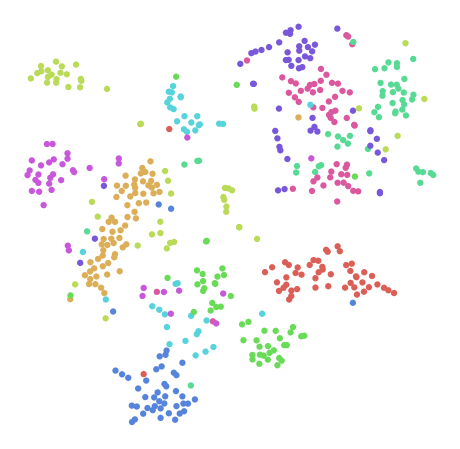

In [201]:
make_gif("test.gif")